In [1]:
import os
os.chdir('C:/Users/aporw/project new/')
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [17]:
from batchers import dataset_constants
from utils.general import colordisplay, load_npz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils.analysis import (
    calc_score,
    chunk_vs_score,
    evaluate_df,
    plot_chunk_vs_score,
    plot_label_vs_score,
    plot_percdata_vs_score,
    sorted_scores)

In [3]:
OUTPUTS_ROOT_DIR = 'outputs'
COUNTRIES = dataset_constants.DHS_COUNTRIES

In [4]:
npz_path = os.path.join(OUTPUTS_ROOT_DIR, 'resnet_nl2', 'test_preds.npz')
npz = load_npz(npz_path)
nl_preds = npz['test_preds']

labels: dtype=float32, shape=(1857,)
test_preds: dtype=float32, shape=(1857,)


In [5]:
npz_path = os.path.join(OUTPUTS_ROOT_DIR, 'resnet_ms2', 'test_preds.npz')
npz = load_npz(npz_path)
ms_preds = npz['test_preds']

labels: dtype=float32, shape=(1857,)
test_preds: dtype=float32, shape=(1857,)


In [6]:
npz_path = os.path.join(OUTPUTS_ROOT_DIR, 'resnet_msnl_concat2', 'test_preds.npz')
npz = load_npz(npz_path)
msnl_preds = npz['test_preds']

labels: dtype=float32, shape=(1857,)
test_preds: dtype=float32, shape=(1857,)


In [7]:
preds_df = pd.DataFrame(
    columns=['lat', 'lon', 'country', 'year', 'label', 'ms_preds', 'nl_preds', 'msnl_preds'])
             
df = pd.read_csv('data/dhs_clusters.csv', float_precision='high', index_col=False)
preds_df['lat'] = df['lat']
preds_df['lon'] = df['lon']
preds_df['label'] = df['wealthscore'].to_numpy(dtype=np.float32)
preds_df['year'] = df['year']
preds_df['country'] = df['country']
preds_df['ms_preds'] = ms_preds
preds_df['nl_preds'] = nl_preds  
preds_df['msnl_preds'] = msnl_preds

In [8]:
with pd.option_context('display.max_rows', 8):
    display(preds_df)
preds_df.to_csv('preds.csv', index=False)

,lat,lon,country,year,label,ms_preds,nl_preds,msnl_preds
0,-1.433492,29.977690,uganda,2016,-0.012811,0.242350,0.212183,0.262254
1,-1.339285,29.699112,uganda,2016,-0.259125,0.036511,0.041795,0.045427
2,-1.324783,29.727349,uganda,2016,-0.422849,0.107864,0.062404,0.094805
3,-1.316605,29.776532,uganda,2016,-0.168625,0.052420,0.055049,0.041450
...,...,...,...,...,...,...,...,...
1853,-9.563763,33.120814,malawi,2015,0.122807,-0.045330,-0.028295,-0.081035
1854,-9.545274,33.203831,malawi,2015,-0.091682,-0.066429,-0.035733,-0.058504
1855,-9.515626,33.331837,malawi,2015,-0.045595,0.138034,0.065304,0.077422
1856,-9.471652,32.985695,malawi,2015,-0.259459,-0.077716,-0.052398,-0.056403


In [9]:
overall_df = evaluate_df(preds_df, cols=['ms_preds', 'nl_preds', 'msnl_preds'])
overall_df.sort_values(by='r2', ascending=False, inplace=True)
overall_df

,r2,R2,mse,rank
msnl_preds,0.003289,-0.019044,1.018495,-0.018864
ms_preds,0.001222,-0.042174,1.041613,-0.003267
nl_preds,0.000463,-0.018646,1.018098,0.013386


In [168]:
npz_path = os.path.join(OUTPUTS_ROOT_DIR, 'resnet_ms', 'ridge_weights.npz')
npz = load_npz(npz_path)
ms_wgts_A_b = npz['A_b']
ms_wgts_B_b = npz['B_b']
ms_wgts_C_b = npz['C_b']

A_w: dtype=float32, shape=(512,)
A_b: dtype=float32, shape=(1,)
B_w: dtype=float32, shape=(512,)
B_b: dtype=float32, shape=(1,)
C_w: dtype=float32, shape=(512,)
C_b: dtype=float32, shape=(1,)


In [170]:
ms_wgts_A_b

array([0.06465095], dtype=float32)

In [171]:
ms_wgts_B_b

array([-0.08762411], dtype=float32)

In [172]:
ms_wgts_C_b

array([0.05897065], dtype=float32)

In [22]:
def plot_predictions(y, yhat, r2, country, max_y=None):
    if max_y is not None:
        yhat = yhat[y < max_y]
        y = y[y < max_y]
    fig = plt.figure(figsize=(8,5))
    plt.scatter(y, yhat, alpha=0.6)
    plt.plot(np.unique(y), np.poly1d(np.polyfit(y, yhat, 1))(np.unique(y)), color='g')
#     plt.axvline(x=2.15, color='r', linestyle='dashed')
    plt.xlabel('Survey Measured')
    plt.ylabel('Satellite Predicted')
    #plt.xlabel('log(Actual Consumption($/day))')
    #plt.ylabel('log(Predicted Consumption($/day))')
    plt.title(f'{country} ($R^2$={round(r2, 4)})')
#     return fig

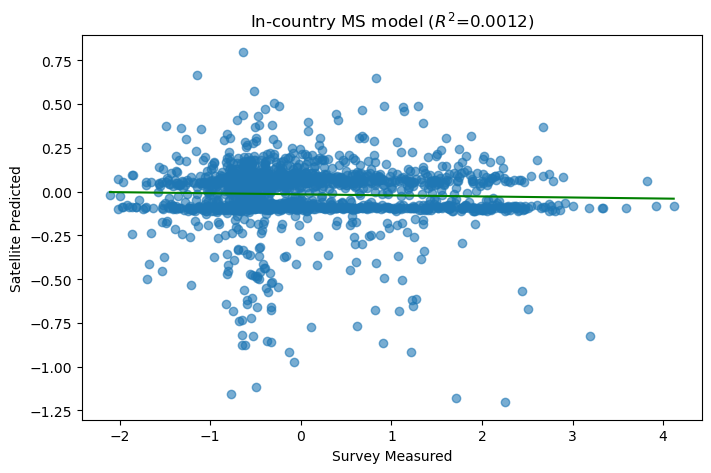

In [23]:
plot_predictions(preds_df['label'], preds_df['ms_preds'], 0.0012, "In-country MS model")

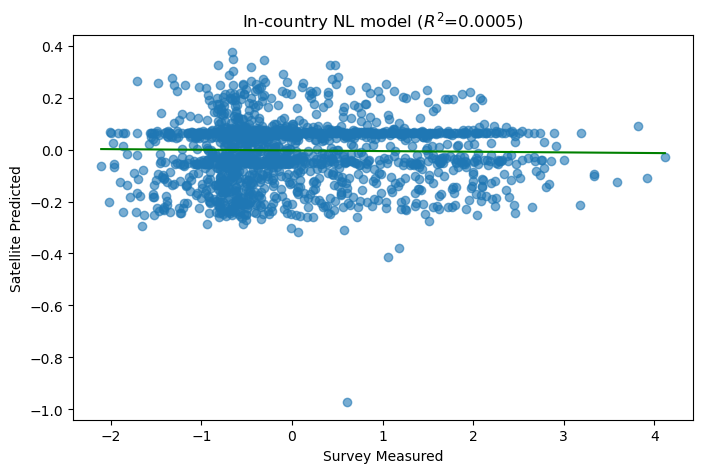

In [24]:
plot_predictions(preds_df['label'], preds_df['nl_preds'], 0.0005, "In-country NL model")

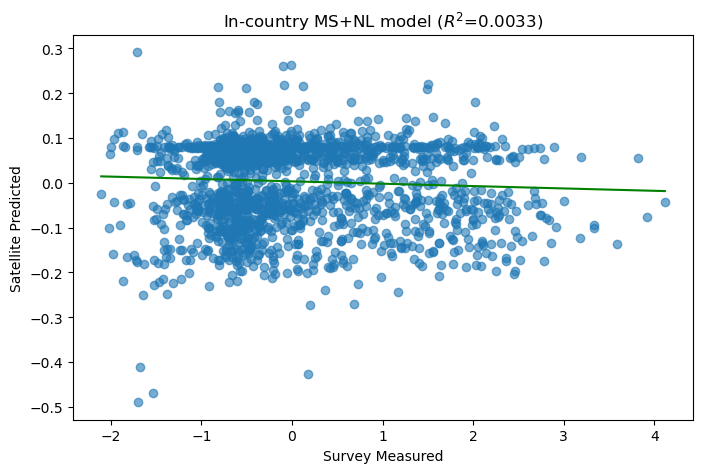

In [25]:
plot_predictions(preds_df['label'], preds_df['msnl_preds'], 0.0033, "In-country MS+NL model")